In [203]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import pandas as pd

import os

from lib.Diccionariacion import awards_wipo, awards_gdp, wipo_gdp
from lib.Tratamiento import inv_dict, interchange_dict
from scipy.optimize import curve_fit
from scipy.stats import linregress, spearmanr
from scipy.optimize import least_squares

In [204]:
#Diccionario OEC

awards_OEC = {
    'Jordan': 'Jordan',
    'Romania': 'Romania',
    'Lebanon': 'Lebanon',
    'South Africa': 'South Africa',
    'France': 'France',
    'Kyrgyzstan': 'Kyrgyzstan',
    'Poland': 'Poland',
    'Chile': 'Chile',
    'Kenya': 'Kenya',
    'Malaysia': 'Malaysia',
    'Chinese Taipei': 'Chinese Taipei',
    'Canada': 'Canada',
    'Turkey': 'Turkey',
    'China': 'China',
    'Italy': 'Italy',
    'United States': 'United States',
    'Cuba': 'Cuba',
    'Pakistan': 'Pakistan',
    'Greece': 'Greece',
    'Norway': 'Norway',
    'Singapore': 'Singapore',
    'Venezuela': 'Venezuela',
    'Costa Rica': 'Costa Rica',
    'Georgia': 'Georgia',
    'Mongolia': 'Mongolia',
    'Brazil': 'Brazil',
    'Kuwait': 'Kuwait',
    'Switzerland': 'Switzerland',
    'Sri Lanka': 'Sri Lanka',
    'Sweden': 'Sweden',
    'Ireland': 'Ireland',
    'Laos': 'Laos',
    'Oman': 'Oman',
    'Guatemala': 'Guatemala',
    'Ecuador': 'Ecuador',
    'Ukraine': 'Ukraine',
    'Israel': 'Israel',
    'Saudi Arabia': 'Saudi Arabia',
    'Botswana': 'Botswana',
    'Albania': 'Albania',
    'Austria': 'Austria',
    'Tanzania': 'Tanzania',
    'Egypt': 'Egypt',
    'Germany': 'Germany',
    'Bulgaria': 'Bulgaria',
    'Moldova': 'Moldova',
    'Uruguay': 'Uruguay',
    'United Arab Emirates': 'United Arab Emirates',
    'New Zealand': 'New Zealand',
    'Azerbaijan': 'Azerbaijan',
    'Bosnia and Herzegovina': 'Bosnia and Herzegovina',
    'Bangladesh': 'Bangladesh',
    'Croatia': 'Croatia',
    'Tajikistan': 'Tajikistan',
    'Russia': 'Russia',
    'Hong Kong': 'Hong Kong',
    'Spain': 'Spain',
    'Vietnam': 'Vietnam',
    'Slovakia': 'Slovakia',
    'Indonesia': 'Indonesia',
    'Iran': 'Iran',
    'Kazakhstan': 'Kazakhstan',
    'Portugal': 'Portugal',
    'Mexico': 'Mexico',
    'North Korea': 'North Korea',
    'Qatar': 'Qatar',
    'Nicaragua': 'Nicaragua',
    'Australia': 'Australia',
    'Philippines': 'Philippines',
    'India': 'India',
    'Hungary': 'Hungary',
    'Slovenia': 'Slovenia',
    'Peru': 'Peru',
    'Lithuania': 'Lithuania',
    'Paraguay': 'Paraguay',
    'United Kingdom': 'United Kingdom',
    'Belgium': 'Belgium',
    'Denmark': 'Denmark',
    'Thailand': 'Thailand',
    'Japan': 'Japan',
    'Dominican Republic': 'Dominican Republic',
    'Belarus': 'Belarus',
    'Colombia': 'Colombia',
    'Czechia': 'Czechia',
    'South Korea': 'South Korea',
    'Argentina': 'Argentina',
    'Tunisia': 'Tunisia',
    'Serbia': 'Serbia',
    'Netherlands': 'Netherlands',
    'Finland': 'Finland',
    'Cameroon': 'Cameroon',
    'Armenia': 'Armenia',
    'Zimbabwe': 'Zimbabwe',
    'Morocco': 'Morocco'
}

In [205]:
#Funciones

def x_vs_y(x_dict, y_dict, x_dict_y, log = False):
    N = len(x_dict)
    XY = np.full((2, N), fill_value = np.nan)
    not_present = []
    i = 0
    for x_name, x_value in x_dict.items():
        try:
            y_name = x_dict_y[x_name]
            y_value = y_dict[y_name]
            if log:
                y_value = np.log1p(y_value)
            XY[:, i] = [x_value, y_value]
        except:
            not_present.append(x_name)
        i += 1
    return XY, not_present

def reg(XY, robust = False):
    
    def model(param, x):
        return param[1] * x + param[0]
        
    def residuals(param, x, y):
        return y - model(param, x)
    
    x, y = XY
    mask = ~(np.isnan(x) + np.isnan(y))
    
    x_data = x[mask]
    y_data = y[mask]
    if robust:
        res_robust = least_squares(residuals, initial_params, args=(x_data, y_data), loss='cauchy')
        slope, intercept = res_robust.x
    else:
        slope, intercept, r, p, se = linregress(x_data, y_data)
    
    res = spearmanr(x_data, y_data)
    XY_reg = np.zeros((2, 2))
    XY_reg[0, :] = [np.min(x_data), np.max(x_data)]
    XY_reg[1, :] = slope * XY_reg[0, :] + intercept
    return XY_reg, [res.statistic, res.pvalue]

def question_anio(root, awards = True):
    splitting = root.split('\\')
    if len(splitting) == 6:
        return splitting[4]
    if awards:
        return '2015-2023'
    else:
        return '2010-2024'

def identity_dict(dicc):
    identity = {
        key : key for key in dicc.keys()
    }
    return identity

def list_to_str(lista, separador = ' '):
    vacio = ''
    for elemento in lista:
        vacio += elemento + f'{separador}'
    return vacio[:-1]

def csv_parser(lista_strings):
    new_lista = []
    for string in lista_strings:
        new_lista.append(string.replace(',', ''))
    return new_lista
    
def save_to_csv(data, nombre_archivo):
    with open(r'./data/datasets/' + nombre_archivo, 'w+', encoding = 'utf-8') as f:
        for row in data:
            f.write(
                list_to_str(csv_parser(row), separador = ',')
            )

def limpieza_html_times(f_read):
    lineas = [i.split('</td>')[:-1] for i in f_read.split('<tr role="row" class=')[1:]]
    golden = []
    filtrado_lineas = [i[1:3] for i in lineas]
    data = []
    k = 1
    for j in filtrado_lineas:
        try:
            Universidad = j[0].split('data-mz="">')[1].split('</a>')[0]
        except:
            Univerisdad = j[0].split('">')[2].split('</div>')[0]
        
        Pais = j[0].split('">')[-1].split('</a>')[0]
        if Pais == 'Explore':
            Pais = j[0].split('">')[-2].split('</a>')[0]
        if '<' in Pais:
            Pais = Pais.split('<')[0]
        try:
            Puntaje_total = j[1].split('>')[1]
        except:
            Puntaje_total = ''
        data.append([Universidad, Pais, Puntaje_total])
        k += 1
    return data

def data_to_json(fisrt):
    json_file = {}
    N = len(fisrt)
    for i in range(N):
        Nombre = fisrt[i]['display_name']
        Pais = fisrt[i]['geo']['country']
        anios = fisrt[i]['counts_by_year']
    
        json_file[Nombre] = {
                'Country' : Pais,
                'Works' : {i_dict['year']:i_dict['works_count'] for i_dict in anios}
        }
    return json_file

def procesar_puntaje(valor):
    if isinstance(valor, str):
        if ('–' in valor):
            a, b = map(float, valor.split('–'))
            return (a + b) / 2
        if ('—' in valor):
            a, b = map(float, valor.split('—'))
            return (a + b) / 2
        if ('n/a' == valor):
            return 0
        if ('-' == valor):
            return 0
        else:
            return float(valor)
    else:
        return valor

In [530]:
#Resultados 

año_awards = r'/'
año_wipo = r'/'
root = r'.'
results_wipo = root + rf'\data\results\wipo{año_wipo}\Ranking_DCI_wipo.csv'
results_awards = root + rf'\data\results\awards{año_awards}\Ranking_DCI_awards.csv'

In [531]:
if año_awards == r'/2020-2023':
    slice_ = 'mean_3'
elif año_awards == r'/2015-2019':
    slice_ = 'mean_2'
else:
    slice_ = 'mean_awards'

slice_

'mean_awards'

In [532]:
año_wipo = question_anio(results_wipo)
año_awards = question_anio(results_awards)

#Datasets
PIB_mean = root + r'\data\datasets\IMF_GDP_per_PPA_April_2024.xlsx'
Design_indicators = root + r'\data\datasets\design-indicators_02.xlsx'
ECI_re_root = root + r'\test\Data-ECI-Research.csv'
ECI_te_root = root + r'\test\Data-ECI-Technology.csv'
ECI_tr_root = root + r'\test\Data-ECI-Trade.csv'
GCI_2011_root = root + r'\data\datasets\GCI2011.csv'
GCI_2015_root = root + r'\data\datasets\GCI2015.csv'
F25_2018_root = root + r'\data\datasets\F25_2018.csv'
F23_2018_root = root + r'\data\datasets\F23_2018.csv'

times_root = root + r'/data/datasets/Times/'
times = os.listdir(times_root)

alex_root = root + r'/data/datasets/Open_Alex/'
alexs = os.listdir(alex_root)

#Diccionarios (awards -> rankings)
dict_root = root + r'\data\datasets\dicts_rankings'
ADA_2023_root = dict_root + r'/ADA_2023_country_match.csv'
GDR_2023_root = dict_root + r'/GDR_2023_country_match.csv'
DCR_2010_root = dict_root + r'/DCR_2010_country_match.csv'
DCR_2008_root = dict_root + r'/DCR_2008_country_match.csv'
DCR_2007_root = dict_root + r'/DCR_2007_country_match.csv'
DCR_2005_root = dict_root + r'/DCR_2005_country_match.csv'
DCR_2002_root = dict_root + r'/DCR_2002_country_match.csv'
IDS_abs_root = dict_root + r'/IDS_abs_country_match.csv'
IDS_rel_root = dict_root + r'/IDS_rel_country_match.csv'

In [533]:
#Cargado de datasets
df_wipo = pd.read_csv(results_wipo, sep = '\t')
df_awards = pd.read_csv(results_awards, sep = '\t')

df_pib = pd.read_excel(PIB_mean).loc[:, ['Country', 'mean_1', 'mean_2', 'mean_3', 'mean_awards']]
df_design = pd.read_excel(Design_indicators, sheet_name = 'Indicators').loc[:, ['country', 'score', 'ranking_name']]

df_gci_2011 = pd.read_csv(GCI_2011_root)
df_gci_2015 = pd.read_csv(GCI_2015_root)

df_f23 = pd.read_csv(F23_2018_root)
df_f25 = pd.read_csv(F25_2018_root)

DCI_awards = df_awards.set_index('category')['DCI'].to_dict()
DCI_wipo = df_wipo.set_index('category')['DCI'].to_dict()

GCI_2011 = df_gci_2011.set_index('Country')['GCI'].to_dict()
GCI_2015 = df_gci_2015.set_index('Country')['GCI'].to_dict()
F25_ = df_f25.set_index('Country')['Total'].to_dict()
F23_ = df_f23.set_index('Country')['Total'].to_dict()

Ranking_Score = {
    ranking: group.set_index('country')['score'].to_dict()
    for ranking, group in df_design.groupby('ranking_name')
}

Ranking_names = list(Ranking_Score.keys())

PIB = {
    'mean_1' : df_pib.set_index('Country')['mean_1'].to_dict(),
    'mean_2' : df_pib.set_index('Country')['mean_2'].to_dict(),
    'mean_3' : df_pib.set_index('Country')['mean_3'].to_dict(),
    'mean_awards' : df_pib.set_index('Country')['mean_awards'].to_dict(),
}

In [534]:
OEC_awards = inv_dict(awards_OEC)

OEC_wipo = interchange_dict(OEC_awards, awards_wipo)

In [535]:
#Cargado de Universidades ranking
df_times = pd.read_csv(times_root + times[2], sep = ';')
df_times['year'] = 2011
df_times['score'] = df_times['score'].apply(procesar_puntaje)

for i, t in enumerate(times[2:]):
    df = pd.read_csv(times_root + t, sep = ';')
    df['year'] = 2012 + i
    df['score'] = df['score'].apply(procesar_puntaje)
    df_times = pd.concat([df_times, df])

df_times.drop('university', axis=1, inplace=True)
agg_prod_times_by_year = df_times.groupby(['year', 'country']).sum().reset_index()

times_mean_1 = agg_prod_times_by_year[ (agg_prod_times_by_year['year'] >= 2015) & (agg_prod_times_by_year['year'] <=2019) ]
times_mean_2 = agg_prod_times_by_year[ agg_prod_times_by_year['year'] > 2019 ]
times_mean_awards = agg_prod_times_by_year

agg_prod_times = times_mean_1.rename(columns = {'score':'sum_2'}).drop(['year'], axis = 1).groupby('country').sum().reset_index()
agg_prod_times['sum_3'] = times_mean_2.drop(['year'], axis = 1).groupby('country').sum().reset_index()['score']
agg_prod_times['sum_awards'] = times_mean_awards.drop(['year'], axis = 1).groupby('country').sum().reset_index()['score']

agg_prod_times['log_sum_2'] = np.log1p(agg_prod_times['sum_2'])
agg_prod_times['log_sum_3'] = np.log1p(agg_prod_times['sum_3'])
agg_prod_times['log_sum_awards'] = np.log1p(agg_prod_times['sum_awards'])


times_score = {
    'mean_2': agg_prod_times.set_index('country')['log_sum_2'].to_dict(),
    'mean_3': agg_prod_times.set_index('country')['log_sum_3'].to_dict(),
    'mean_awards': agg_prod_times.set_index('country')['log_sum_awards'].to_dict()
}

In [536]:
df_open_alex = pd.read_csv(alex_root + alexs[0], sep = ';')
for alex in alexs[1:-1]:
    df = pd.read_csv(alex_root + alex, sep = ';')
    df_open_alex = pd.concat([df_open_alex, df])

df_open_alex.drop('institution', axis=1, inplace=True)
agg_prod_alex_by_year = df_open_alex.groupby(['year', 'country']).sum().reset_index()
agg_prod_alex_by_year = agg_prod_alex_by_year[
    (agg_prod_alex_by_year['year'] >= 2015) & (agg_prod_alex_by_year['year'] < 2024)
]

alex_mean_1 = agg_prod_alex_by_year[ (agg_prod_alex_by_year['year'] >= 2015) & (agg_prod_alex_by_year['year'] <=2019) ]
alex_mean_2 = agg_prod_alex_by_year[ agg_prod_alex_by_year['year'] > 2019 ]
alex_mean_awards = agg_prod_alex_by_year

agg_prod_alex = alex_mean_1.rename(columns = {'production':'sum_2'}).drop(['year'], axis = 1).groupby('country').sum().reset_index()
agg_prod_alex['sum_3'] = alex_mean_2.drop(['year'], axis = 1).groupby('country').sum().reset_index()['production']
agg_prod_alex['sum_awards'] = alex_mean_awards.drop(['year'], axis = 1).groupby('country').sum().reset_index()['production']

agg_prod_alex['log_sum_2'] = np.log1p(agg_prod_alex['sum_2'])
agg_prod_alex['log_sum_3'] = np.log1p(agg_prod_alex['sum_3'])
agg_prod_alex['log_sum_awards'] = np.log1p(agg_prod_alex['sum_awards'])


alex_score = {
    'mean_2': agg_prod_alex.set_index('country')['log_sum_2'].to_dict(),
    'mean_3': agg_prod_alex.set_index('country')['log_sum_3'].to_dict(),
    'mean_awards': agg_prod_alex.set_index('country')['log_sum_awards'].to_dict()
}

In [537]:
df_tr = pd.read_csv(ECI_tr_root).loc[:, '2010':'Country' ]
df_te = pd.read_csv(ECI_te_root).loc[:, '2010':'Country' ]
df_re = pd.read_csv(ECI_re_root).loc[:, '2010':'Country' ]

df_tr['mean_1'] = df_tr.loc[:, '2010':'2014' ].mean(axis = 1)
df_tr['mean_2'] = df_tr.loc[:, '2015':'2019' ].mean(axis = 1)
df_tr['mean_3'] = df_tr.loc[:, '2020':'2023' ].mean(axis = 1)
df_tr['mean_awards'] = df_tr.loc[:, '2015':'2023' ].mean(axis = 1)

df_re['mean_1'] = df_re.loc[:, '2010':'2014' ].mean(axis = 1)
df_re['mean_2'] = df_re.loc[:, '2015':'2019' ].mean(axis = 1)
df_re['mean_3'] = df_re.loc[:, '2020':'2023' ].mean(axis = 1)
df_re['mean_awards'] = df_re.loc[:, '2015':'2023' ].mean(axis = 1)

df_te['mean_1'] = df_te.loc[:, '2010':'2014' ].mean(axis = 1)
df_te['mean_2'] = df_te.loc[:, '2015':'2019' ].mean(axis = 1)
df_te['mean_3'] = df_te.loc[:, '2020':'2023' ].mean(axis = 1)
df_te['mean_awards'] = df_te.loc[:, '2015':'2023' ].mean(axis = 1)

df_tr = df_tr[['Country', 'mean_1', 'mean_2', 'mean_3', 'mean_awards']]
df_te = df_te[['Country', 'mean_1', 'mean_2', 'mean_3', 'mean_awards']]
df_re = df_re[['Country', 'mean_1', 'mean_2', 'mean_3', 'mean_awards']]

ECI_tr = {
    col: df_tr.set_index('Country')[col].to_dict()
    for col in ['mean_1', 'mean_2', 'mean_3', 'mean_awards']
}

ECI_te = {
    col: df_te.set_index('Country')[col].to_dict()
    for col in ['mean_1', 'mean_2', 'mean_3', 'mean_awards']
}

ECI_re = {
    col: df_re.set_index('Country')[col].to_dict()
    for col in ['mean_1', 'mean_2', 'mean_3', 'mean_awards']
}

ECIs = {
    'ECI_tr': ECI_tr,
    'ECI_te': ECI_te,
    'ECI_re': ECI_re
}

ECI_names = list(ECIs.keys())

In [538]:
GCIs = {
    'GCI_2011' : GCI_2011,
    'GCI_2015' : GCI_2015
}

GCI_names = GCIs.keys()

In [539]:
F23 = {}
F25 = {}

for key, value in F23_.items():
    if value == '..':
        F23[key] = np.nan
    else:
        F23[key] = float(value)

for key, value in F25_.items():
    if value == '..':
        F25[key] = np.nan
    else:
        F25[key] = float(value)

Fs = {
    'F23_2018' : F23,
    'F25_2018' : F25
}

F_names = Fs.keys()

In [540]:
#Diccionarios (awards -> ranking_score)
ADA_2023_dict = pd.read_csv(ADA_2023_root).set_index('country_in_awards')['country_in_data'].to_dict()
GDR_2023_dict = pd.read_csv(GDR_2023_root).set_index('country_in_awards')['country_in_data'].to_dict()
DCR_2010_dict = pd.read_csv(DCR_2010_root).set_index('country_in_awards')['country_in_data'].to_dict()
DCR_2008_dict = pd.read_csv(DCR_2008_root).set_index('country_in_awards')['country_in_data'].to_dict()
DCR_2007_dict = pd.read_csv(DCR_2007_root).set_index('country_in_awards')['country_in_data'].to_dict()
DCR_2005_dict = pd.read_csv(DCR_2005_root).set_index('country_in_awards')['country_in_data'].to_dict()
DCR_2002_dict = pd.read_csv(DCR_2002_root).set_index('country_in_awards')['country_in_data'].to_dict()
IDS_abs_dict = pd.read_csv(IDS_abs_root).set_index('country_in_awards')['country_in_data'].to_dict()
IDS_rel_dict = pd.read_csv(IDS_rel_root).set_index('country_in_awards')['country_in_data'].to_dict()

Ranking_dicts = [
    ADA_2023_dict,
    DCR_2002_dict,
    DCR_2005_dict,
    DCR_2007_dict,
    DCR_2008_dict,
    DCR_2010_dict,
    GDR_2023_dict,
    IDS_abs_dict,
    IDS_rel_dict
]

In [541]:
wipo_awards = inv_dict(awards_wipo)

In [542]:
folder = 'thre_075/'
mask_ = False
save = False
plt.rcParams.update({'font.size': 16})

## Gráficos

## DCI award vs DCI wipo

### Se considera award total (2015-2023), wipo (2010-2014) y media PIB per capita (2015-2023)
#### Award: (c, p) min = (15, 10)
#### wipo: (c, p) min = (10, 0)
#### Threshold = 0.5

Awards vs Wipo: (2, 85)


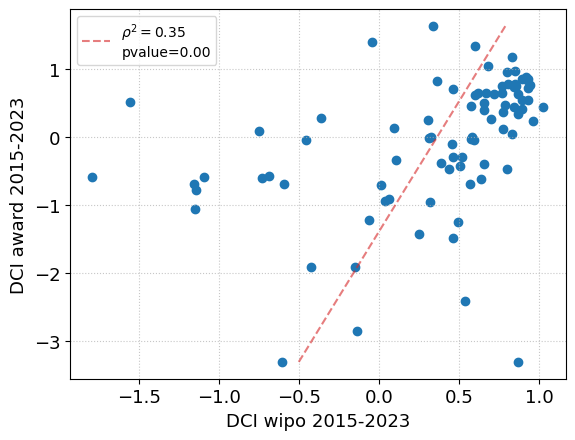

In [543]:
#DCI award vs DCI wipo
plt.rcParams.update({'font.size': 13})

DCIs, non_present = x_vs_y(DCI_awards, DCI_wipo, wipo_awards)
mask_0 = ~(np.isnan(DCIs[0, :]) & np.isnan(DCIs[1, :]))

print(f'Awards vs Wipo: {DCIs[:, mask_0].shape}')

if mask_:
    mask1 = ~(np.isnan(DCIs[0, :]) & np.isnan(DCIs[1, :]))
    mask2 = DCIs[0, mask1] < 6
    DCIs = DCIs[:, mask1][:, mask2]

DCI_reg, values = reg(DCIs, robust = False)

plt.scatter(DCIs[1, :], DCIs[0, :])
plt.plot(DCI_reg[1, :], DCI_reg[0, :], linestyle = '--', alpha = 0.6, color = 'tab:red', label = f'$\\rho^2=${values[0]**2:.2f}\npvalue={values[1]:.2f}')
plt.legend(fontsize = 10)
plt.grid(alpha = 0.7, linestyle = ':')
plt.ylabel(f'DCI award {año_awards}')
plt.xlabel(f'DCI wipo {año_wipo}')

if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs.png')

## DCI awards vs GDP per capita

Awards vs PIB: (2, 102)
Wipo vs PIB: (2, 144)


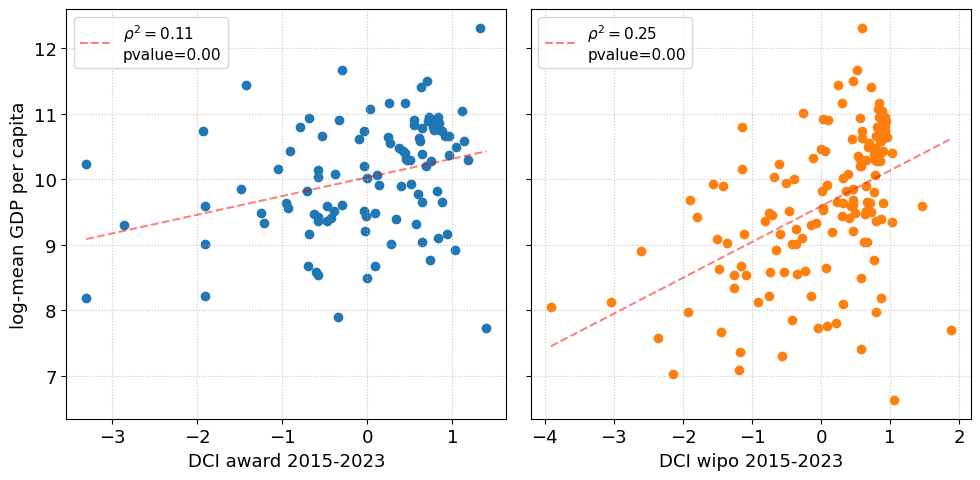

In [544]:
#DCIs vs GDP per capita
escalabilidad = 1

DCIa_PIB, non_present = x_vs_y(DCI_awards, PIB[slice_], awards_gdp, log = True)
DCIw_PIB, non_present = x_vs_y(DCI_wipo, PIB[slice_], wipo_gdp, log = True)

mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))

print(f'Awards vs PIB: {DCIa_PIB[:, mask_a].shape}')
print(f'Wipo vs PIB: {DCIw_PIB[:, mask_w].shape}')

if mask_:
    mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask2 = DCIa_PIB[0, mask1] < 6
    DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]


DCIa_reg, values_a = reg(DCIa_PIB)
DCIw_reg, values_w = reg(DCIw_PIB)

fig, ax = plt.subplots(1, 2, figsize = (escalabilidad * 10, escalabilidad * 5), sharey = True)

ax[0].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :])
ax[0].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2=${values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}')
ax[0].set_xlabel(f'DCI award {año_awards}')
ax[0].set_ylabel(f'log-mean GDP per capita')
ax[0].legend(fontsize = 11, loc = 'upper left')
ax[0].grid(alpha = 0.7, linestyle = ':')

ax[1].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange')
ax[1].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2=${values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}')
ax[1].set_xlabel(f'DCI wipo {año_wipo}')
ax[1].legend(fontsize = 11, loc = 'upper left')
ax[1].grid(alpha = 0.7, linestyle = ':')

plt.tight_layout()
if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs_GDP.png')

## DCI vs GDR 2023

Awards vs GDR2023: (2, 8)
Wipo vs GDR2023: (2, 8)


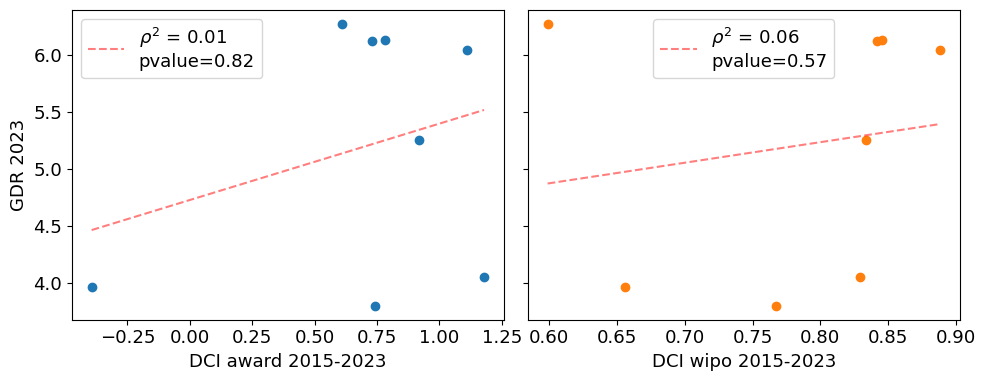

In [545]:
#DCI award vs GDR 2023
wipo_ranking = interchange_dict(wipo_awards, GDR_2023_dict)
DCIa_PIB, non_present_a = x_vs_y(DCI_awards, Ranking_Score['GDR_2023'], GDR_2023_dict)
DCIw_PIB, non_present_w = x_vs_y(DCI_wipo, Ranking_Score['GDR_2023'], wipo_ranking)

mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))

print(f'Awards vs GDR2023: {DCIa_PIB[:, mask_a].shape}')
print(f'Wipo vs GDR2023: {DCIw_PIB[:, mask_w].shape}')

if mask_:
    mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask2 = DCIa_PIB[0, mask1] < 6
    DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]

DCIa_reg, values_a = reg(DCIa_PIB)
DCIw_reg, values_w = reg(DCIw_PIB)

fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharey = True)

ax[0].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :])
ax[0].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}')
ax[0].set_xlabel(f'DCI award {año_awards}')
ax[0].set_ylabel(f'GDR 2023')
ax[0].legend()



ax[1].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange')
ax[1].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}')
ax[1].set_xlabel(f'DCI wipo {año_wipo}')
ax[1].legend()

plt.tight_layout()
if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs_GDR2023.png')

## DCI vs DCR 20XX

Awards vs ADA_2023: (2, 104)
Wipo vs ADA_2023: (2, 95)

Awards vs DCR_2002: (2, 10)
Wipo vs DCR_2002: (2, 9)

Awards vs DCR_2005: (2, 10)
Wipo vs DCR_2005: (2, 9)

Awards vs DCR_2007: (2, 10)
Wipo vs DCR_2007: (2, 9)

Awards vs DCR_2008: (2, 46)
Wipo vs DCR_2008: (2, 43)

Awards vs DCR_2010: (2, 45)
Wipo vs DCR_2010: (2, 42)

Awards vs GDR_2023: (2, 8)
Wipo vs GDR_2023: (2, 8)

Awards vs IDS_abs: (2, 11)
Wipo vs IDS_abs: (2, 10)

Awards vs IDS_rel: (2, 11)
Wipo vs IDS_rel: (2, 10)



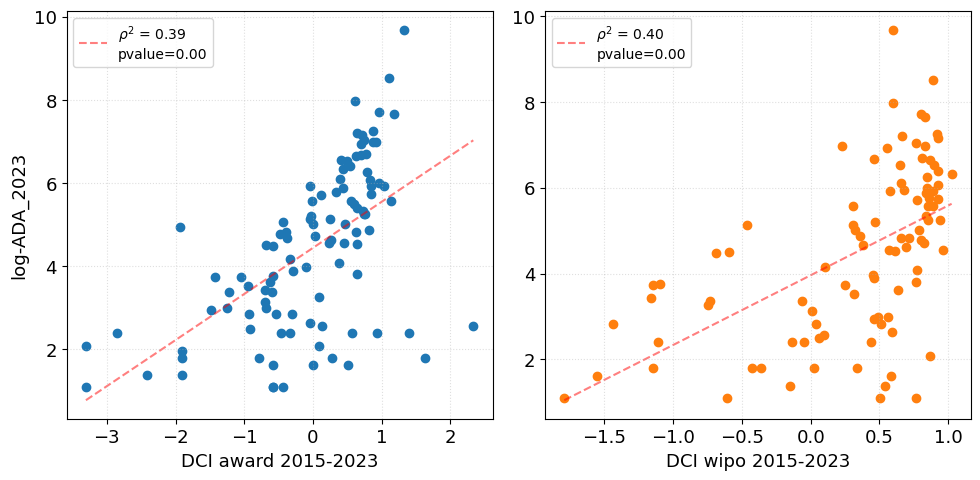

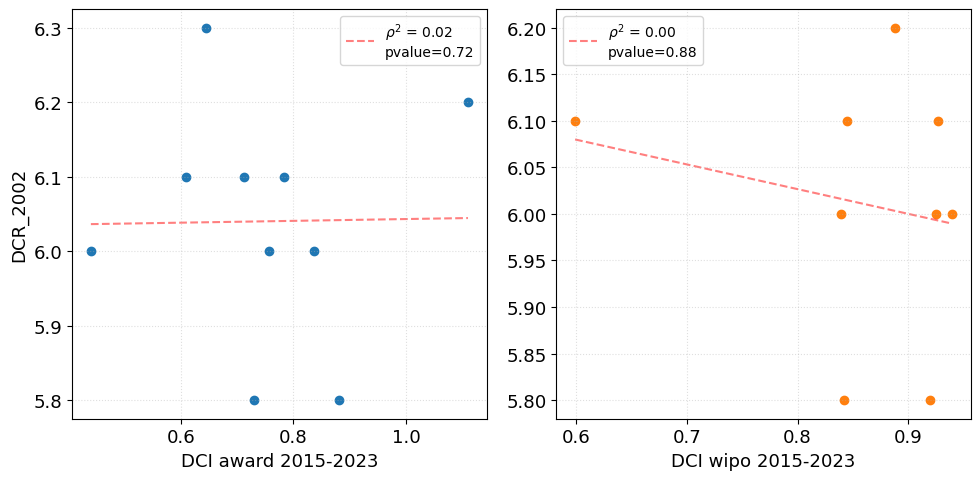

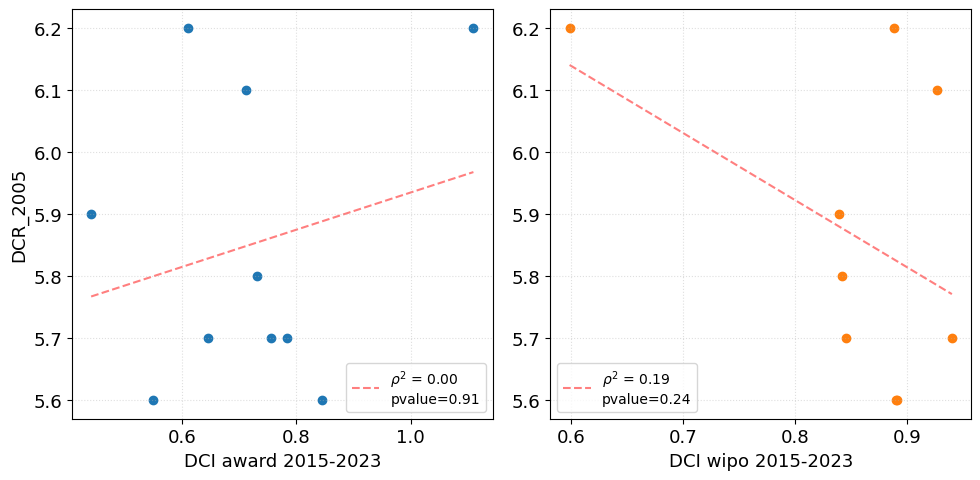

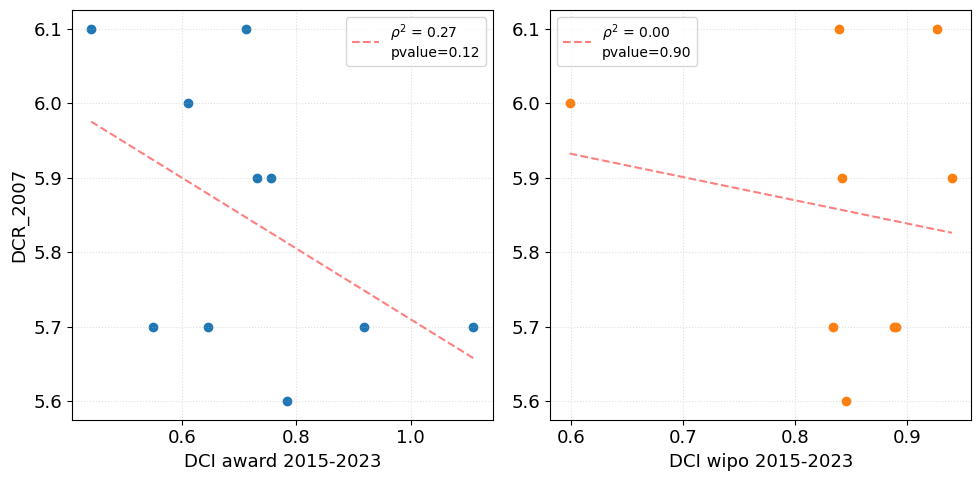

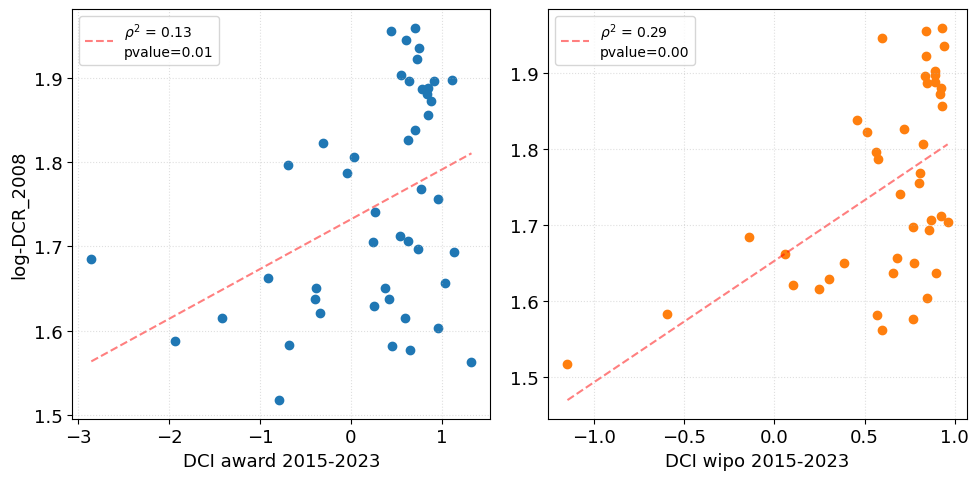

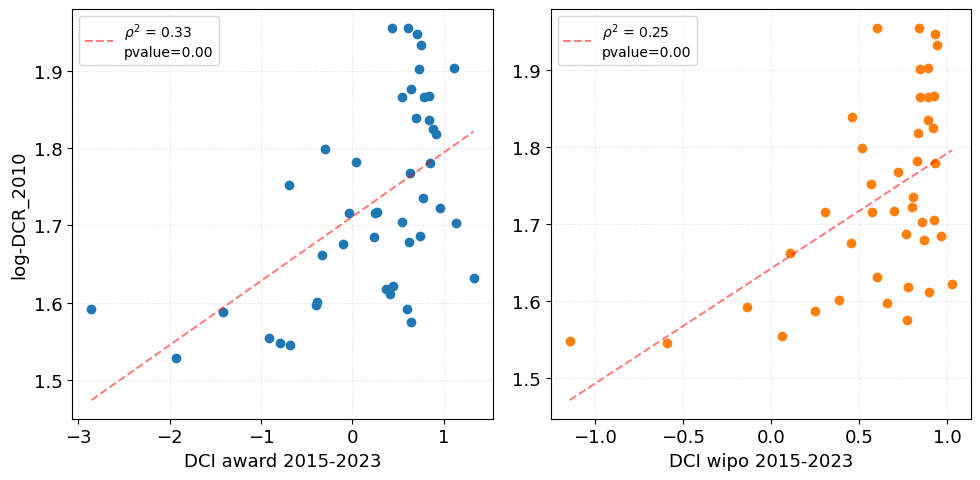

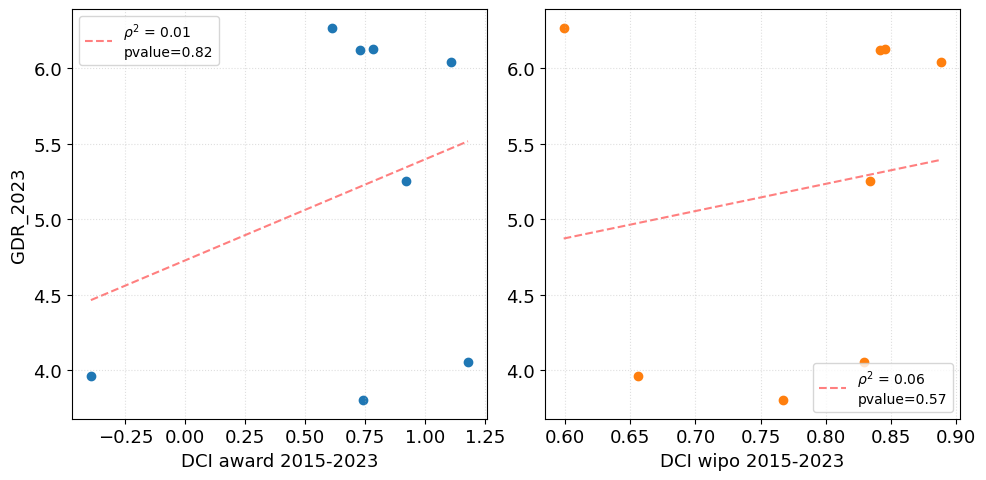

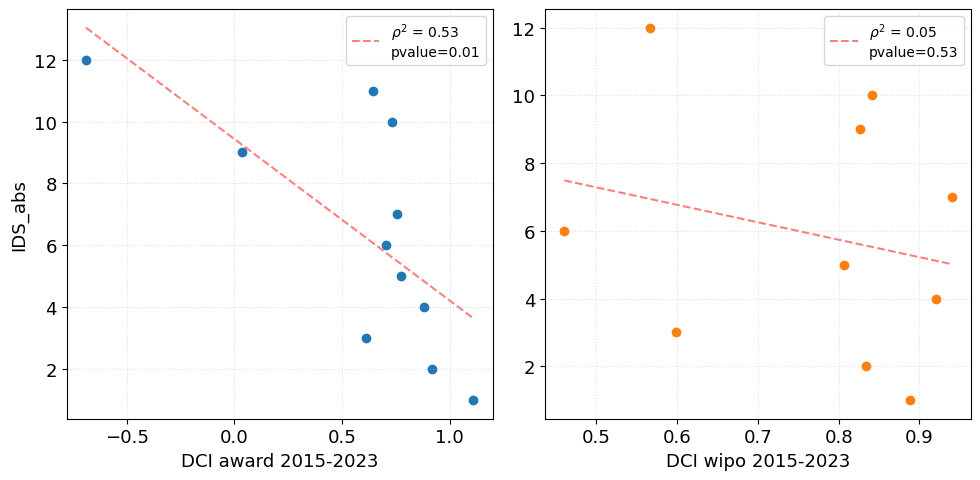

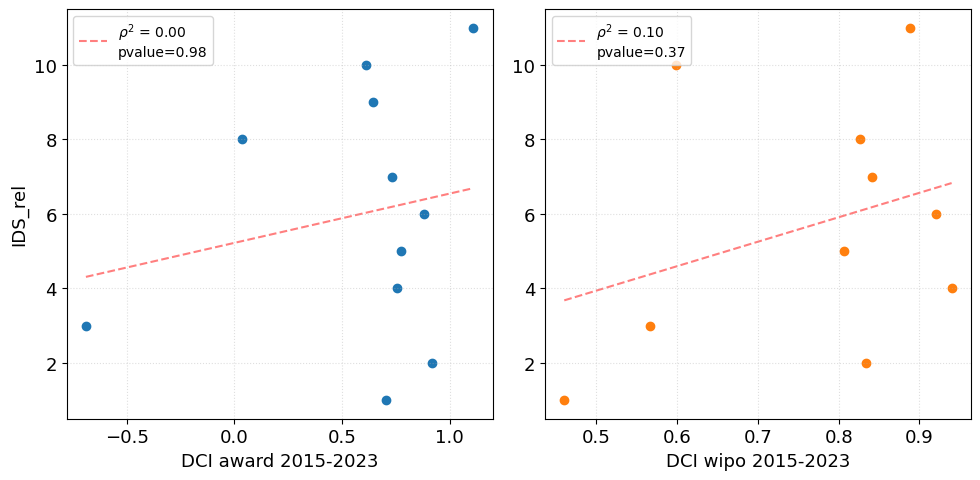

In [546]:
#DCI award vs GDP per capita

for n, rank in enumerate(Ranking_names):
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))

    is_log = (n in [0, 4, 5])
    
    wipo_ranking = interchange_dict(wipo_awards, Ranking_dicts[n])
    DCIa_PIB, non_present = x_vs_y(DCI_awards, Ranking_Score[rank], Ranking_dicts[n], log = is_log)
    DCIw_PIB, non_present = x_vs_y(DCI_wipo, Ranking_Score[rank], wipo_ranking, log = is_log)

    mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))
    
    print(f'Awards vs {rank}: {DCIa_PIB[:, mask_a].shape}')
    print(f'Wipo vs {rank}: {DCIw_PIB[:, mask_w].shape}\n')

    if mask_:
        mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
        mask2 = DCIa_PIB[0, mask1] < 6
        DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]
    
    DCIa_reg, values_a = reg(DCIa_PIB)
    DCIw_reg, values_w = reg(DCIw_PIB)
    
    ax[0].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :], zorder = 1)
    ax[0].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}', zorder = 1)
    ax[0].set_ylabel( is_log * 'log-' + f'{rank}')
    ax[0].legend(fontsize = 10)
    ax[0].grid(zorder = 0, alpha = 0.4, linestyle = ':')
    
    ax[1].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange', zorder = 1)
    ax[1].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}', zorder = 1)
    ax[1].legend(fontsize = 10)
    ax[1].grid(zorder = 0, alpha = 0.4, linestyle = ':')

    ax[0].set_xlabel(f'DCI award {año_awards}')
    ax[1].set_xlabel(f'DCI wipo {año_wipo}')
    plt.tight_layout()

    if save:
        plt.savefig(f'./figs/correlations/{folder}DCIs_{rank}.png')

## DCI vs IDS

Awards vs IDS_abs: (2, 11)
Wipo vs IDS_abs: (2, 10)
Awards vs IDS_rel: (2, 6)
Wipo vs IDS_rel: (2, 5)


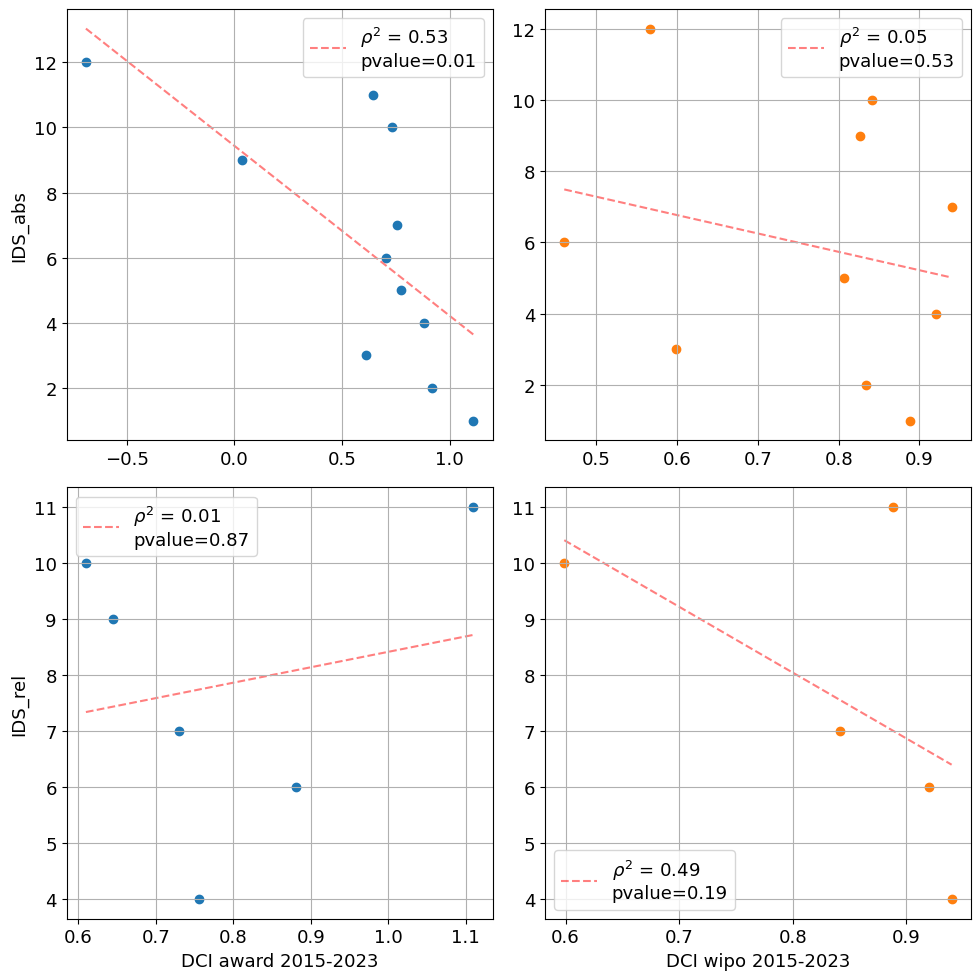

In [547]:
fig, ax = plt.subplots(2, 2, figsize = (10, 5 * 2))

for n, rank in enumerate(Ranking_names[7:]):
    wipo_ranking = interchange_dict(wipo_awards, Ranking_dicts[n])
    DCIa_PIB, non_present = x_vs_y(DCI_awards, Ranking_Score[rank], Ranking_dicts[n])
    DCIw_PIB, non_present = x_vs_y(DCI_wipo, Ranking_Score[rank], wipo_ranking)

    mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))
    
    print(f'Awards vs {rank}: {DCIa_PIB[:, mask_a].shape}')
    print(f'Wipo vs {rank}: {DCIw_PIB[:, mask_w].shape}')

    if mask_:
        mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
        mask2 = DCIa_PIB[0, mask1] < 6
        DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]
    
    DCIa_reg, values_a = reg(DCIa_PIB)
    DCIw_reg, values_w = reg(DCIw_PIB)
    
    ax[n, 0].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :], zorder = 1)
    ax[n, 0].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}', zorder = 1)
    ax[n, 0].set_ylabel(f'{rank}')
    ax[n, 0].legend()
    ax[n, 0].grid(zorder = 0)
    
    ax[n, 1].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange', zorder = 1)
    ax[n, 1].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}', zorder = 1)
    ax[n, 1].legend()
    ax[n, 1].grid(zorder = 0)

ax[1, 0].set_xlabel(f'DCI award {año_awards}')
ax[1, 1].set_xlabel(f'DCI wipo {año_wipo}')
plt.tight_layout()

if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs_IDS.png')

Awards vs ECI_tr: (2, 91)
Wipo vs ECI_tr: (2, 84)
Awards vs ECI_te: (2, 91)
Wipo vs ECI_te: (2, 84)
Awards vs ECI_re: (2, 91)
Wipo vs ECI_re: (2, 84)


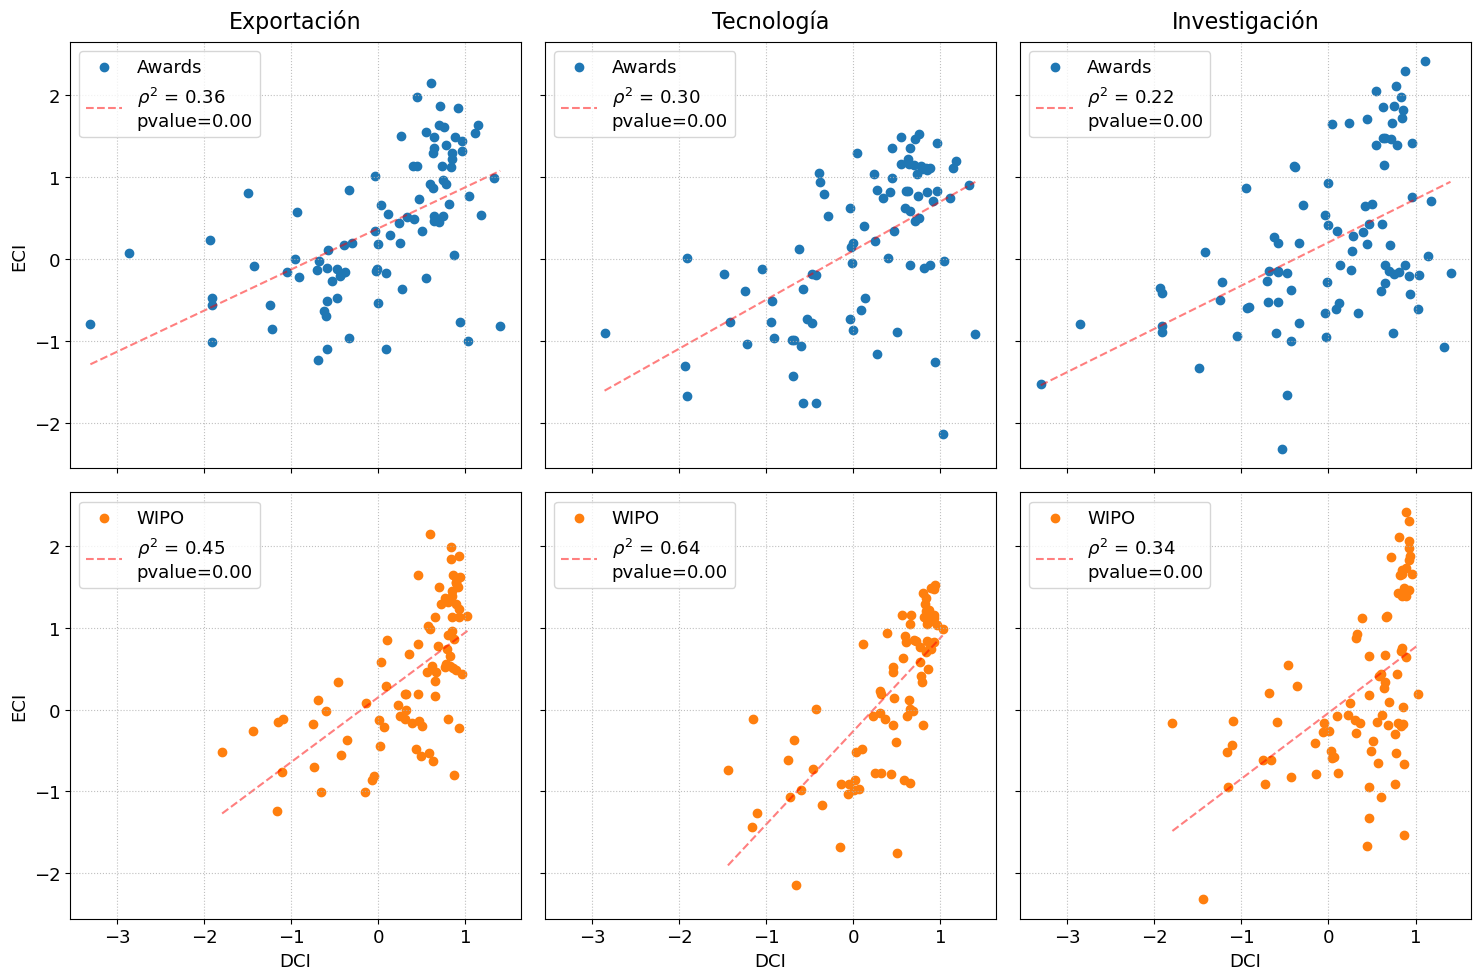

In [548]:
fig, ax = plt.subplots(2, 3, figsize = (5 * 3, 10), sharex = True, sharey = True)

for n, rank in enumerate(ECI_names):
    wipo_ranking = interchange_dict(wipo_awards, awards_OEC)
    DCIa_PIB, non_present = x_vs_y(DCI_awards, ECIs[rank][slice_], awards_OEC)
    DCIw_PIB, non_present = x_vs_y(DCI_wipo, ECIs[rank][slice_], wipo_ranking)

    mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))
    
    print(f'Awards vs {rank}: {DCIa_PIB[:, mask_a].shape}')
    print(f'Wipo vs {rank}: {DCIw_PIB[:, mask_w].shape}')

    if mask_:
        mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
        mask2 = DCIa_PIB[0, mask1] < 6
        DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]
    
    DCIa_reg, values_a = reg(DCIa_PIB)
    DCIw_reg, values_w = reg(DCIw_PIB)
    
    ax[0, n].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :], zorder = 1, label = 'Awards')
    ax[0, n].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}', zorder = 1)
    ax[0, n].legend(loc = 'upper left', fontsize = 13)
    ax[0, n].grid(zorder = 0, alpha = 0.8, linestyle = ':')
    
    ax[1, n].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange', zorder = 1, label = 'WIPO')
    ax[1, n].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}', zorder = 1)
    ax[1, n].legend(loc = 'upper left', fontsize = 13)
    ax[1, n].grid(zorder = 0, alpha = 0.8, linestyle = ':')

    #ax[1, 0].set_xlabel(f'DCI award {año_awards}')
    #ax[1, 1].set_xlabel(f'DCI wipo {año_wipo}')
    ax[0, 0].set_ylabel(f'ECI')
    ax[1, 0].set_ylabel(f'ECI')

for n, titulos in enumerate(['Exportación', 'Tecnología', 'Investigación']):
    ax[0, n].set_title(titulos, pad = 10, fontsize = 16)
    ax[1, n].set_xlabel('DCI')

plt.tight_layout()
if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs_ECIs.png')

## DCIs vs GCIs

Awards vs GCI_2011: (2, 67)
Wipo vs GCI_2011: (2, 61)
Awards vs GCI_2015: (2, 84)
Wipo vs GCI_2015: (2, 79)


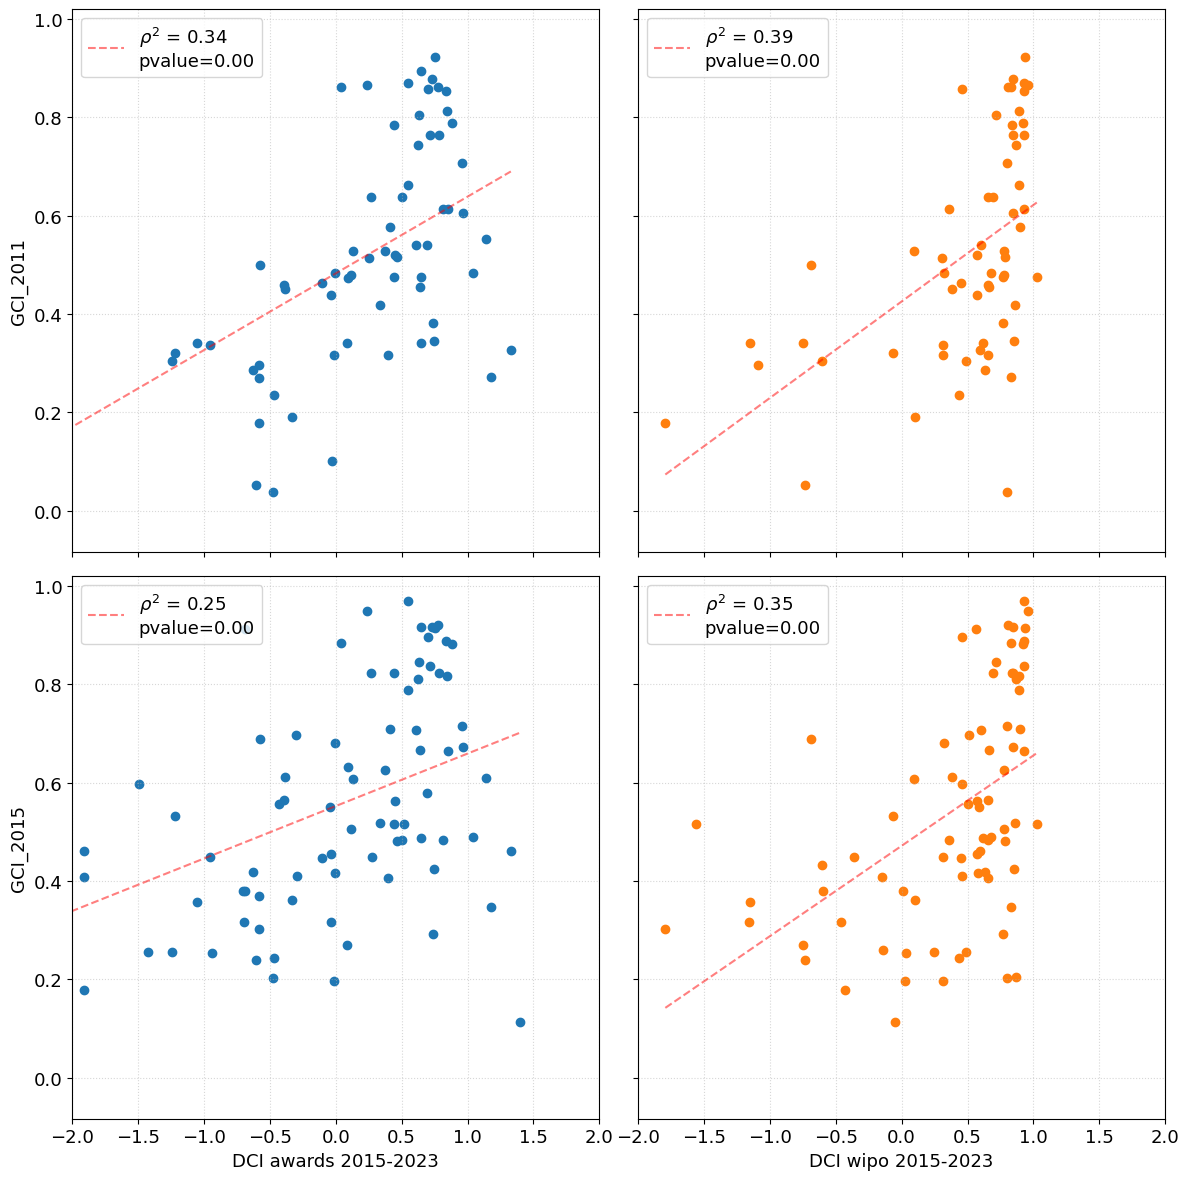

In [549]:
#DCI award vs GDR 2023
fig, ax = plt.subplots(2, 2, figsize = (12, 12), sharey = True, sharex = True)
for n, rank in enumerate(GCI_names):
    DCIa_PIB, non_present_a = x_vs_y(DCI_awards, GCIs[rank], awards_wipo)
    DCIw_PIB, non_present_w = x_vs_y(DCI_wipo, GCIs[rank], identity_dict(awards_wipo))
    
    mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))
    
    print(f'Awards vs {rank}: {DCIa_PIB[:, mask_a].shape}')
    print(f'Wipo vs {rank}: {DCIw_PIB[:, mask_w].shape}')

    if mask_:
        mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
        mask2 = DCIa_PIB[0, mask1] < 6
        DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]
    
    DCIa_reg, values_a = reg(DCIa_PIB)
    DCIw_reg, values_w = reg(DCIw_PIB)
    
    ax[n, 0].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :])
    ax[n, 0].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}')
    ax[n, 0].set_ylabel(f'{rank}')
    ax[n, 0].legend(loc = 'upper left', fontsize = 13)
    ax[n, 0].grid(alpha = 0.5, linestyle = ':')
    ax[n, 0].set_xlim([-2, 2])

    ax[n, 1].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange')
    ax[n, 1].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}')
    ax[n, 1].legend(loc = 'upper left', fontsize = 13)
    ax[n, 1].grid(alpha = 0.5, linestyle = ':')

ax[1, 0].set_xlabel(f'DCI awards {año_awards}')
ax[1, 1].set_xlabel(f'DCI wipo {año_wipo}')
plt.tight_layout()

if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs_GCIs.png')

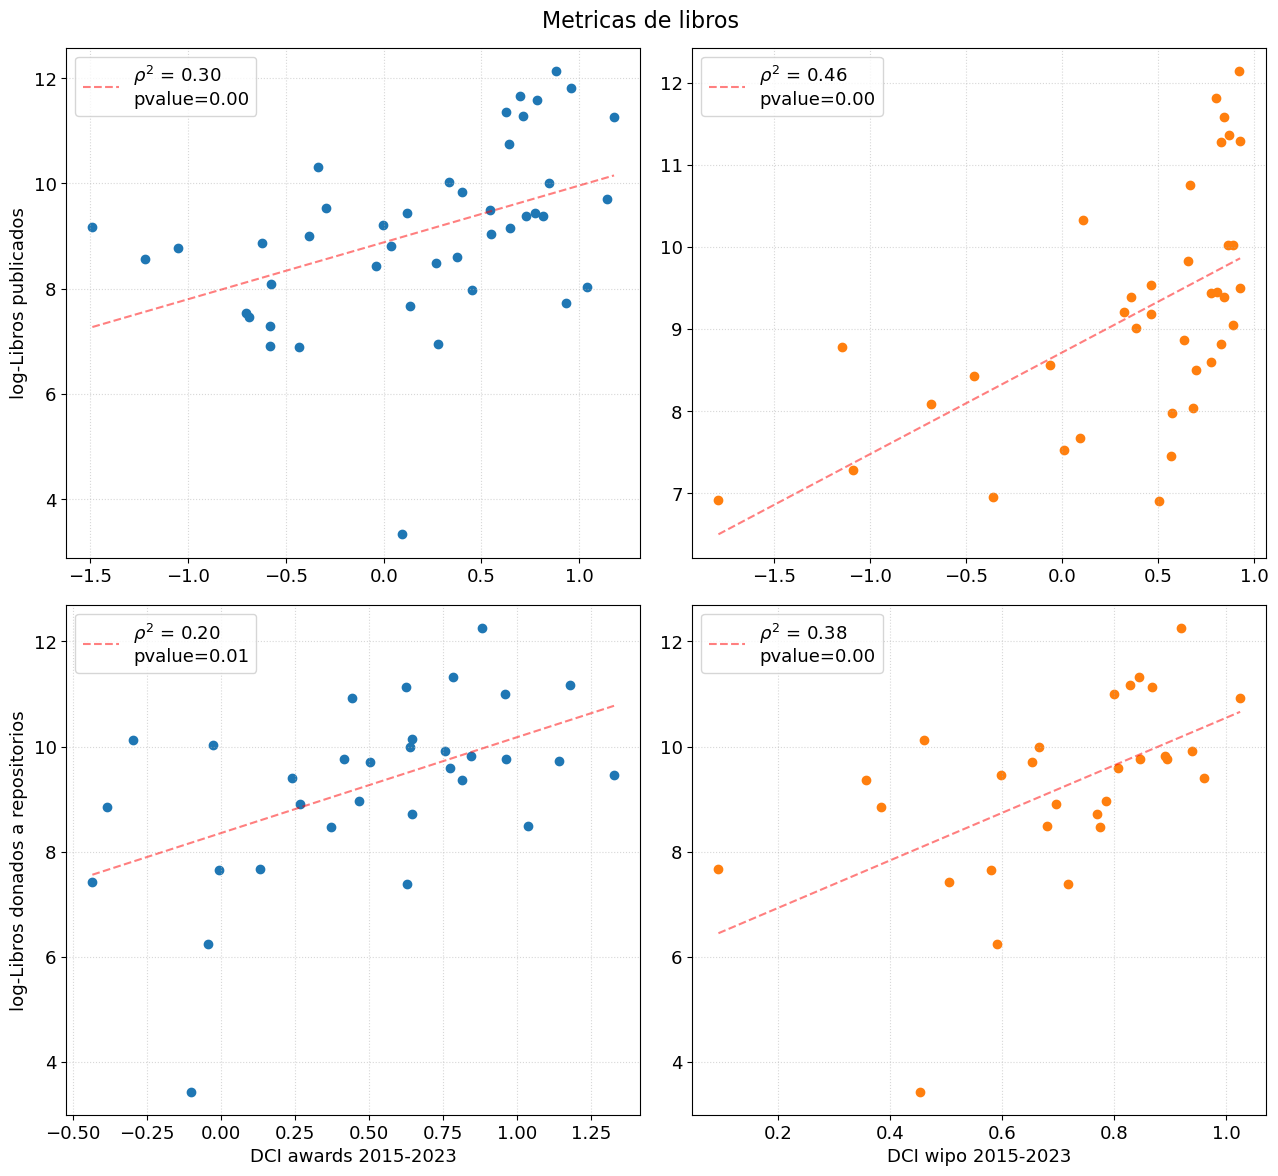

In [550]:
#Libros publicados
fig, ax = plt.subplots(2, 2, figsize = (13, 12))
Nombres_y = ['Libros publicados', 'Libros donados a repositorios']

for n, rank in enumerate(F_names):
    DCIa_PIB, non_present_a = x_vs_y(DCI_awards, Fs[rank], awards_wipo, log = True)
    DCIw_PIB, non_present_w = x_vs_y(DCI_wipo, Fs[rank], identity_dict(awards_wipo), log = True)

    if mask_:
        mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
        mask2 = DCIa_PIB[0, mask1] < 6
        DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]
    
    DCIa_reg, values_a = reg(DCIa_PIB)
    DCIw_reg, values_w = reg(DCIw_PIB)
    
    ax[n, 0].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :])
    ax[n, 0].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}')
    ax[n, 0].set_ylabel(f'log-{Nombres_y[n]}')
    ax[n, 0].legend(loc = 'upper left', fontsize = 13)
    ax[n, 0].grid(alpha = 0.5, linestyle = ':')
    
    ax[n, 1].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange')
    ax[n, 1].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}')
    ax[n, 1].legend(loc = 'upper left', fontsize = 13)
    ax[n, 1].grid(alpha = 0.5, linestyle = ':')

ax[1, 0].set_xlabel(f'DCI awards {año_awards}')
ax[1, 1].set_xlabel(f'DCI wipo {año_wipo}')
fig.suptitle('Metricas de libros', fontsize = 16)

plt.tight_layout()
if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs_Fs.png')

Awards vs Times: (2, 68)
Wipo vs Times: (2, 66)


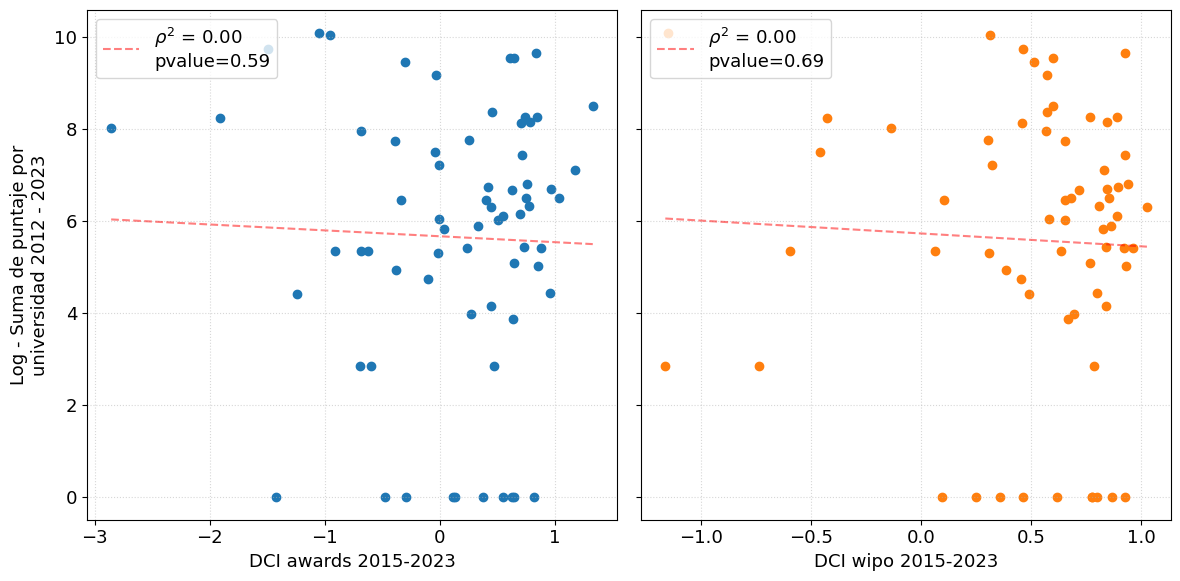

In [551]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6), sharey = True)

DCIa_PIB, non_present_a = x_vs_y(DCI_awards, times_score[slice_], awards_wipo)
DCIw_PIB, non_present_w = x_vs_y(DCI_wipo, times_score[slice_], identity_dict(awards_wipo))

if mask_:
    mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask2 = DCIa_PIB[0, mask1] < 6
    DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]

DCIa_reg, values_a = reg(DCIa_PIB)
DCIw_reg, values_w = reg(DCIw_PIB)

mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))

print(f'Awards vs Times: {DCIa_PIB[:, mask_a].shape}')
print(f'Wipo vs Times: {DCIw_PIB[:, mask_w].shape}')

ax[0].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :])
ax[0].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}')
ax[0].set_ylabel(f'Log - Suma de puntaje por\nuniversidad 2012 - 2023')
ax[0].legend(loc = 'upper left', fontsize = 13)
ax[0].grid(alpha = 0.5, linestyle = ':')

ax[1].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange')
ax[1].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}')
ax[1].legend(loc = 'upper left', fontsize = 13)
ax[1].grid(alpha = 0.5, linestyle = ':')

ax[0].set_xlabel(f'DCI awards {año_awards}')
ax[1].set_xlabel(f'DCI wipo {año_wipo}')
plt.tight_layout()
if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs_Times.png')

Awards vs Alex: (2, 88)
Wipo vs Alex: (2, 84)


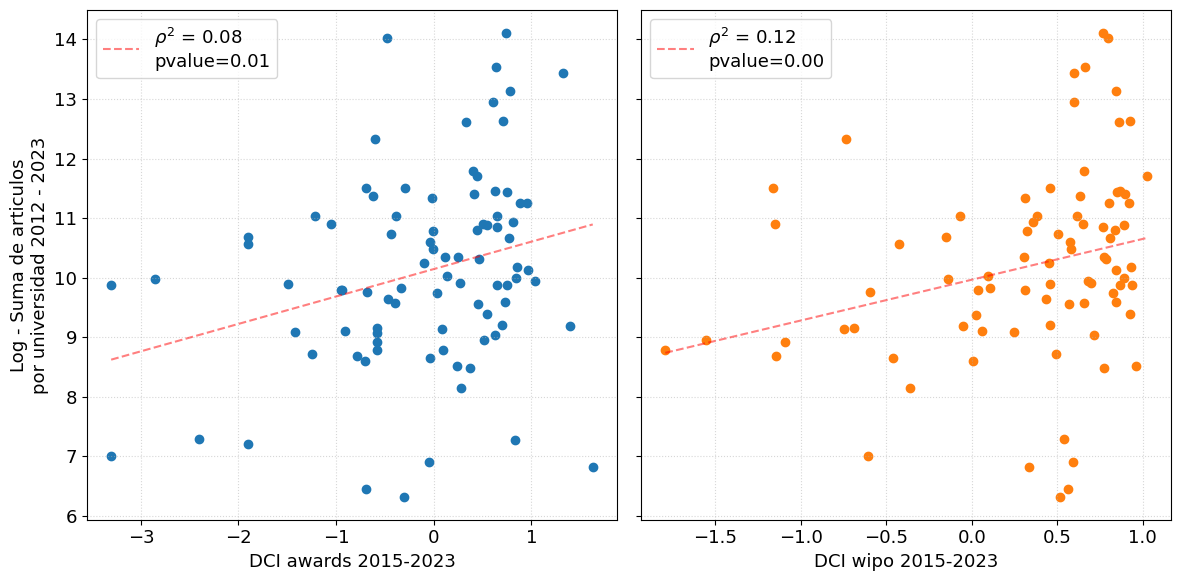

In [552]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6), sharey = True)

DCIa_PIB, non_present_a = x_vs_y(DCI_awards, alex_score[slice_], awards_wipo)
DCIw_PIB, non_present_w = x_vs_y(DCI_wipo, alex_score[slice_], identity_dict(awards_wipo))

mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))

print(f'Awards vs Alex: {DCIa_PIB[:, mask_a].shape}')
print(f'Wipo vs Alex: {DCIw_PIB[:, mask_w].shape}')

if mask_:
    mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask2 = DCIa_PIB[0, mask1] < 6
    DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]

DCIa_reg, values_a = reg(DCIa_PIB)
DCIw_reg, values_w = reg(DCIw_PIB)

ax[0].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :])
ax[0].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}')
ax[0].set_ylabel(f'Log - Suma de articulos\npor universidad 2012 - 2023')
ax[0].legend(loc = 'upper left', fontsize = 13)
ax[0].grid(alpha = 0.5, linestyle = ':')

ax[1].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange')
ax[1].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}')
ax[1].legend(loc = 'upper left', fontsize = 13)
ax[1].grid(alpha = 0.5, linestyle = ':')

ax[0].set_xlabel(f'DCI awards {año_awards}')
ax[1].set_xlabel(f'DCI wipo {año_wipo}')
plt.tight_layout()

if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs_Alex.png')

Awards vs ECI_tr: (2, 63)
Wipo vs ECI_tr: (2, 84)

Awards vs ECI_te: (2, 63)
Wipo vs ECI_te: (2, 84)

Awards vs ECI_re: (2, 63)
Wipo vs ECI_re: (2, 84)



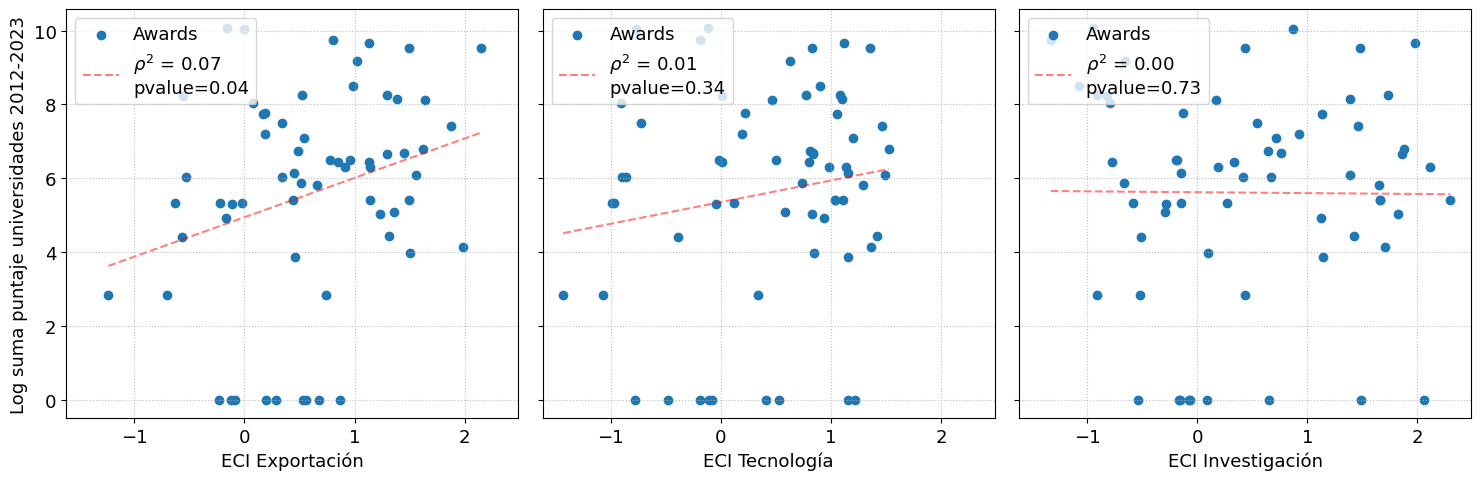

In [553]:
fig, ax = plt.subplots(1, 3, figsize = (5 * 3, 5), sharex = True, sharey = True)

for n, rank in enumerate(ECI_names):
    wipo_ranking = interchange_dict(wipo_awards, awards_OEC)
    DCIa_PIB, non_present = x_vs_y(ECIs[rank][slice_], times_score[slice_], OEC_wipo)

    mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))
    
    print(f'Awards vs {rank}: {DCIa_PIB[:, mask_a].shape}')
    print(f'Wipo vs {rank}: {DCIw_PIB[:, mask_w].shape}\n')
    
    DCIa_reg, values_a = reg(DCIa_PIB)
    
    ax[n].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :], zorder = 1, label = 'Awards')
    ax[n].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}', zorder = 1)
    ax[n].legend(loc = 'upper left', fontsize = 13)
    ax[n].grid(zorder = 0, alpha = 0.8, linestyle = ':')

    #ax[1, 0].set_xlabel(f'DCI award {año_awards}')
    #ax[1, 1].set_xlabel(f'DCI wipo {año_wipo}')
    ax[0].set_ylabel(f'Log suma puntaje universidades 2012-2023')

for n, titulos in enumerate(['Exportación', 'Tecnología', 'Investigación']):
    ax[n].set_xlabel(f'ECI {titulos}')

plt.tight_layout()

In [554]:
# Normalizar las llaves de los diccionarios usando equivalencias
def normalizar_diccionario(dic, equivalencias):
    resultado = {}
    for k, v in dic.items():
        clave_normalizada = equivalencias.get(k, k)
        resultado[clave_normalizada] = v
    return resultado


# Normalizar ambos diccionarios
dict1_norm = normalizar_diccionario(DCI_awards, awards_wipo)
dict2_norm = normalizar_diccionario(DCI_wipo, {})
dict3_norm = normalizar_diccionario(PIB[slice_], inv_dict(wipo_gdp))
dict4_norm = normalizar_diccionario(ECIs['ECI_tr'][slice_], inv_dict(wipo_ranking))
dict5_norm = normalizar_diccionario(ECIs['ECI_re'][slice_], inv_dict(wipo_ranking))
dict6_norm = normalizar_diccionario(ECIs['ECI_te'][slice_], inv_dict(wipo_ranking))
dict7_norm = normalizar_diccionario(Fs['F23_2018'], identity_dict(wipo_ranking))
dict8_norm = normalizar_diccionario(Fs['F25_2018'], identity_dict(wipo_ranking))
dict9_norm = normalizar_diccionario(times_score[slice_], awards_wipo)
dict10_norm = normalizar_diccionario(alex_score[slice_], awards_wipo)


times_score, identity_dict(awards_wipo)
# Crear dataframe combinando
todos_paises = set(dict1_norm) | set(dict2_norm)
datos = []

for pais in todos_paises:
    valor1 = dict1_norm.get(pais, None)
    valor2 = dict2_norm.get(pais, None)
    valor3 = dict3_norm.get(pais, None)
    valor4 = dict4_norm.get(pais, None)
    valor5 = dict5_norm.get(pais, None)
    valor6 = dict6_norm.get(pais, None)
    valor7 = dict7_norm.get(pais, None)
    valor8 = dict8_norm.get(pais, None)
    valor9 = dict9_norm.get(pais, None)
    valor10 = dict10_norm.get(pais, None)
    datos.append({
        'País': pais,
        'DCI_awards': valor1,
        'DCI_wipo': valor2,
        'PIB_per_capita': valor3,
        'ECI_tr': valor4,
        'ECI_re': valor5,
        'ECI_te': valor6,
        'F23_2018': valor7,
        'F25_2018': valor8,
        'Times_Score': valor9,
        'Alex_Score': valor10
        
    })

df = pd.DataFrame(datos)

# (Opcional) ordenar por nombre de país
df = df.sort_values('País').reset_index(drop=True)

df

,País,DCI_awards,DCI_wipo,PIB_per_capita,ECI_tr,ECI_re,ECI_te,F23_2018,F25_2018,Times_Score,Alex_Score
0,Albania,NaN,0.023159,13846.883222,-0.442051,-0.499734,-0.858354,NaN,NaN,NaN,9.370075
1,Algeria,NaN,-0.716100,12704.436444,-0.971127,-1.193709,-0.696108,NaN,NaN,0.000000,11.745655
2,Andorra,NaN,0.022015,55232.062667,NaN,NaN,NaN,NaN,NaN,NaN,5.877736
3,Antigua and Barbuda,NaN,-1.422994,19972.507111,NaN,NaN,NaN,NaN,NaN,NaN,7.758761
4,Argentina,-0.004615,0.322426,22353.942444,0.185651,0.924384,0.191185,9931.0,NaN,7.211557,10.781079
...,...,...,...,...,...,...,...,...,...,...,...
160,Venezuela (Bolivarian Republic of),0.933830,-1.108115,9553.149889,-0.766828,-0.426421,-1.259270,2275.0,NaN,4.741011,9.654257
161,Viet Nam,-0.026978,0.470521,9944.317778,-0.142768,-0.948585,0.147266,NaN,22720.0,NaN,11.325209
162,Yemen,NaN,-2.354177,1958.228333,-1.098975,-1.237020,NaN,NaN,NaN,NaN,1.098612
163,Zambia,NaN,-0.908986,3355.308333,-0.758841,-0.112452,NaN,NaN,NaN,NaN,9.780020


In [555]:
print(slice_)
if slice_ == 'mean_2':
    df.to_csv('./test/DataFrame_2015_2019.csv')
elif slice_ == 'mean_3':
    df.to_csv('./test/DataFrame_2020_2024.csv')
else:
    df.to_csv('./test/DataFrame_Total.csv')

mean_awards


In [556]:
set(DCI_awards)

{'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahrain',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Bulgaria',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'Estonia',
 'Finland',
 'France',
 'Georgia',
 'Germany',
 'Greece',
 'Guatemala',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iran',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Jordan',
 'Kazakhstan',
 'Kenya',
 'Kosovo',
 'Kuwait',
 'Kyrgyzstan',
 'Laos',
 'Latvia',
 'Lebanon',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Malaysia',
 'Maldives',
 'Malta',
 'Mexico',
 'Moldova',
 'Monaco',
 'Mongolia',
 'Montenegro',
 'Morocco',
 'Netherlands',
 'New Zealand',
 'Nicaragua',
 'North Korea',
 'Norway',
 'Oman',
 'Pakistan',
 'Paraguay',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Qatar',
 'Romania',
 

In [557]:
cat_dict = {'Furniture Design Award Category.': 0, 'Graphics, Illustration and Visual Communication Design Award Category.': 1, 'Architecture, Building and Structure Design Award Category.': 2, 'Jewelry, Eyewear and Watch Design Award Category.': 3, 'Packaging Design Award Category.': 4, 'Lighting Products and Lighting Projects Design Award Category.': 5, 'Arts, Crafts and Ready-Made Design Award Category.': 6, 'Bakeware, Tableware, Drinkware and Cookware Design Award Category.': 7, 'Fashion and Travel Accessories Design Award Category.': 8, 'Website and Web Design Award Category.': 9, 'Sustainable Products, Projects and Green Design Award Category.': 10, 'Advertising, Marketing and Communication Design Award Category.': 11, "Baby, Kids' and Children's Products Design Award Category.": 12, 'Interior Space and Exhibition Design Award Category.': 13, 'Street Furniture Design Award Category.': 14, 'Mobile Technologies, Applications and Software Design Award Category.': 15, 'Toy, Games and Hobby Products Design Award Category.': 16, 'Building Materials and Construction Components Design Award Category.': 17, 'Digital and Electronic Devices Design Award Category.': 18, 'Fashion, Apparel and Garment Design Award Category.': 19, 'Print and Published Media Design Award Category.': 20, 'Vehicle, Mobility and Transportation Design Award Category.': 21, 'Medical Devices and Medical Equipment Design Award Category.': 22, 'Photography and Photo Manipulation Design Award Category.': 23, 'Social Design Award Category.': 24, 'Art Materials, Stationery Supplies and Gift Items Design Award Category.': 25, 'Home Appliances Design Award Category.': 26, "Differently Abled and Seniors' Assistance Design Award Category.": 27, 'Textile, Fabric, Textures, Patterns and Cloth Design Award Category.': 28, 'Bathroom Furniture and Sanitary Ware Design Award Category.': 29, 'Interface and Interaction Design Award Category.': 30, 'Pet Supplies and Products for Animals Design Award Category.': 31, 'Movie, Video and Animation Design Award Category.': 32, 'Cultural Heritage and Culture Industry Design Award Category.': 33, 'Sports, Entertainment and Recreation Equipment Design Award Category.': 34, 'Engineering and Technical Design Award Category.': 35, 'Limited Edition and Custom Design Award Category.': 36, 'Idea Design Award Category.': 37, 'Yacht and Marine Vessels Design Award Category.': 38, '3D Printed Forms and Products Design Award Category.': 39, 'Education, Teaching Aid and Training Content Design Award Category.': 40, 'Prosumer Products, Tools, and Machinery Design Award Category.': 41, 'Safety Clothing and Personal Protective Equipment Design Award Category.': 42, 'Computer Graphics and 3D Model Design Award Category.': 43, 'Futuristic Design Award Category.': 44, 'Security, Safety and Surveillance Products Design Award Category.': 45, 'Event and Happening Design Award Category.': 46, 'Footwear, Shoes and Boots Design Award Category.': 47, 'Hospitality, Recreation, Travel and Tourism Design Award Category.': 48, 'Luxury Design Award Category.': 49, 'Beauty, Personal Care and Cosmetic Products Design Award Category.': 50, 'Energy Products, Projects and Devices Design Award Category.': 51, 'Food, Beverage and Culinary Arts Design Award Category.': 52, 'Landscape Planning and Garden Design Award Category.': 53, 'Musical Instruments Design Award Category.': 54, 'Wearable Technologies Design Award Category.': 55, 'Design Quality and Innovation Award Category.': 56, 'Furniture Accessories, Hardware and Materials Design Award Category.': 57, 'Meta, Strategic and Service Design Award Category.': 58, 'Office Furniture Design Award Category.': 59, 'Public Awareness, Volunteerism, and Society Design Award Category.': 60, 'Robotics, Automaton and Automation Design Award Category.': 61, 'Audio and Sound Equipment Design Award Category.': 62, 'Generative, Algorithmic and Parametric Design Award Category.': 63, 'Hardware, Power and Hand Tools Design Award Category.': 64, 'Urban Planning and Urban Design Award Category.': 65, 'Agricultural Tools, Equipment and Machinery Design Award Category.': 66, 'Performing Arts, Style and Scenery Design Award Category.': 67, 'Awards, Prize and Competitions Design Award Category.': 68, 'Construction and Real Estate Projects Design Award Category.': 69, 'Garden and Outdoor Furniture Design Award Category.': 70, 'Music, Audio and Sound Design Award Category.': 71, 'Aerospace and Aircraft Design Award Category.': 72, 'Cybernetics, Prosthesis and Implant Design Award Category.': 73, 'Disposable and Single-Use Product Design Award Category.': 74, 'Heating, Ventilation, and Air Conditioning Products Design Award Category.': 75, 'Kitchen Furniture, Equipment and Fixtures Design Award Category.': 76, 'Manufacturing and Processing Machinery Design Award Category.': 77, 'Car and Land Based Motor Vehicles Design Award Category.': 78, 'Digital and Broadcasting Media Design Award Category.': 79, 'Information Technologies Design Award Category.': 80, 'Outdoor Gear and Camping Equipment Design Award Category.': 81, 'Wholesale, Retail Trade, Commerce and E-Commerce Design Award Category.': 82, 'Camera and Photography Equipment Design Award Category.': 83, 'Computers and Peripheral Devices Design Award Category.': 84, 'Engineering, Construction and Infrastructure Design Award Category.': 85, 'Hospitality, Restaurant and Catering Products Design Award Category.': 86, 'Office and Business Appliances Design Award Category.': 87, 'Scientific Instruments and Research Equipment Design Award Category.': 88, 'Video and Broadcasting Equipment Design Award Category.': 89, 'Heavy Machinery Design Award Category.': 90, 'Vehicle Parts, Auto Accessories and Care Products Design Award Category.': 91, 'Entertainment, Content Creation and Streaming Media Design Award Category.': 92, 'Industrial Equipment and Heavy-duty Appliances Design Award Category.': 93}

In [558]:
inv_number_dict = inv_dict(cat_dict)

In [559]:
inv_number_dict

{0: 'Furniture Design Award Category.',
 1: 'Graphics, Illustration and Visual Communication Design Award Category.',
 2: 'Architecture, Building and Structure Design Award Category.',
 3: 'Jewelry, Eyewear and Watch Design Award Category.',
 4: 'Packaging Design Award Category.',
 5: 'Lighting Products and Lighting Projects Design Award Category.',
 6: 'Arts, Crafts and Ready-Made Design Award Category.',
 7: 'Bakeware, Tableware, Drinkware and Cookware Design Award Category.',
 8: 'Fashion and Travel Accessories Design Award Category.',
 9: 'Website and Web Design Award Category.',
 10: 'Sustainable Products, Projects and Green Design Award Category.',
 11: 'Advertising, Marketing and Communication Design Award Category.',
 12: "Baby, Kids' and Children's Products Design Award Category.",
 13: 'Interior Space and Exhibition Design Award Category.',
 14: 'Street Furniture Design Award Category.',
 15: 'Mobile Technologies, Applications and Software Design Award Category.',
 16: 'Toy, 

In [560]:
inv_number_dict[82]

'Wholesale, Retail Trade, Commerce and E-Commerce Design Award Category.'

In [561]:
comunidades = [{67, 71, 79, 18, 22, 32, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 52, 54, 61},
{64, 65, 66, 70, 72, 73, 74, 77, 80, 85, 86, 88, 51, 53, 55, 56, 58, 60, 62, 63},
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 19, 21, 26},
{33, 36, 11, 13, 48, 49, 20, 23, 24, 25, 27, 28, 29, 30, 31},
{68, 75, 76, 78, 81, 82, 83, 87, 89, 90, 91, 92, 93},
{57, 59, 84, 69}]

In [562]:
for comunidad in comunidades:
    for i in comunidad:
        print(inv_number_dict[i])
    print('')

Performing Arts, Style and Scenery Design Award Category.
Music, Audio and Sound Design Award Category.
Digital and Broadcasting Media Design Award Category.
Digital and Electronic Devices Design Award Category.
Medical Devices and Medical Equipment Design Award Category.
Movie, Video and Animation Design Award Category.
Sports, Entertainment and Recreation Equipment Design Award Category.
Engineering and Technical Design Award Category.
Idea Design Award Category.
Yacht and Marine Vessels Design Award Category.
3D Printed Forms and Products Design Award Category.
Education, Teaching Aid and Training Content Design Award Category.
Prosumer Products, Tools, and Machinery Design Award Category.
Safety Clothing and Personal Protective Equipment Design Award Category.
Computer Graphics and 3D Model Design Award Category.
Futuristic Design Award Category.
Security, Safety and Surveillance Products Design Award Category.
Event and Happening Design Award Category.
Footwear, Shoes and Boots De